# Assignment: GANs with Hands


For this assignment, you will build a Generative Adversarial Network (GAN) that generates pictures of hands. These will be trained on a dataset of hand images doing sign language.

The model you will build will be very similar to the DCGAN model that you saw in the second lab. Feel free to review it in case you get stuck with any of the required steps.

## Imports

In [2]:
#%matplotlib inline
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import urllib
import zipfile

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [8]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## Get the training data

You will download the dataset and extract it to a directory in your workspace. As mentioned, these are images of human hands performing sign language.

In [4]:
# download the dataset
training_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Resources/signs-training.zip"
training_file_name = "signs-training.zip"
urllib.request.urlretrieve(training_url, training_file_name)

# extract to local directory
training_dir = "/data/signs"
zip_ref = zipfile.ZipFile(training_file_name, 'r')
zip_ref.extractall(training_dir)
zip_ref.close()

## Preprocess the images

Next, you will prepare the dataset to a format suitable for the model. You will read the files, convert it to a tensor of floats, then normalize the pixel values.

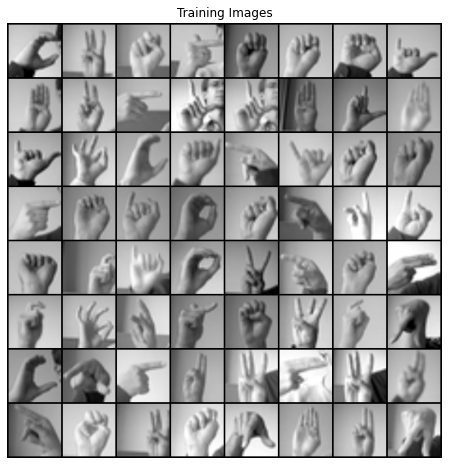

In [9]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=training_dir,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Build the generator

You are free to experiment but here is the recommended architecture:
- *Dense*: number of units should equal `7 * 7 * 128`, input_shape takes in a list containing the random normal dimensions.
    - `random_normal_dimensions` is a hyperparameter that defines how many random numbers in a vector you'll want to feed into the generator as a starting point for generating images.
- *Reshape*: reshape the vector to a 7 x 7 x 128 tensor.
- *BatchNormalization*
- *Conv2DTranspose*: takes `64` units, kernel size is `5`, strides is `2`, padding is `SAME`, activation is `selu`.
- *BatchNormalization*
- *Conv2DTranspose*: `1` unit, kernel size is `5`, strides is `2`, padding is `SAME`, and activation is `tanh`.

In [10]:
# Generator Code

# Built using the sequential class
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the generator
netG = Generator(ngpu).to(device)

In [12]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Build the discriminator

Here is the recommended architecture for the discriminator:
- *Conv2D*: 64 units, kernel size of 5, strides of 2, padding is SAME, activation is a leaky relu with alpha of 0.2, input shape is 28 x 28 x 1
- *Dropout*: rate is 0.4 (fraction of input units to drop)
- *Conv2D*: 128 units, kernel size of 5, strides of 2, padding is SAME, activation is LeakyRelu with alpha of 0.2
- *Dropout*: rate is 0.4.
- *Flatten*
- *Dense*: with 1 unit and a sigmoid activation

In [13]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [14]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Compile the Discriminator and Generator


In [15]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Train the GAN

Phase 1
- real_batch_size: Get the batch size of the input batch (it's the zero-th dimension of the tensor)
- noise: Generate the noise using `tf.random.normal`.  The shape is batch size x random_normal_dimension
- fake images: Use the generator that you just created. Pass in the noise and produce fake images.
- mixed_images: concatenate the fake images with the real images.
  - Set the axis to 0.
- discriminator_labels: Set to `0.` for fake images and `1.` for real images.
- Set the discriminator as trainable.
- Use the discriminator's `train_on_batch()` method to train on the mixed images and the discriminator labels.


Phase 2
- noise: generate random normal values with dimensions batch_size x random_normal_dimensions
  - Use `real_batch_size`.
- Generator_labels: Set to `1.` to mark the fake images as real
  - The generator will generate fake images that are labeled as real images and attempt to fool the discriminator.
- Set the discriminator to NOT be trainable.
- Train the GAN on the noise and the generator labels.

In [16]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/215]	Loss_D: 1.6430	Loss_G: 5.3959	D(x): 0.5411	D(G(z)): 0.5501 / 0.0073
[0/5][50/215]	Loss_D: 0.0801	Loss_G: 20.7949	D(x): 0.9470	D(G(z)): 0.0000 / 0.0000
[0/5][100/215]	Loss_D: 0.0006	Loss_G: 37.9793	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[0/5][150/215]	Loss_D: 0.0005	Loss_G: 37.8947	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[0/5][200/215]	Loss_D: 0.0002	Loss_G: 37.3943	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[1/5][0/215]	Loss_D: 0.0001	Loss_G: 36.9441	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[1/5][50/215]	Loss_D: 0.0012	Loss_G: 29.9868	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000
[1/5][100/215]	Loss_D: 0.4534	Loss_G: 3.3618	D(x): 0.7616	D(G(z)): 0.0787 / 0.0446
[1/5][150/215]	Loss_D: 0.5449	Loss_G: 2.9484	D(x): 0.7003	D(G(z)): 0.0727 / 0.0736
[1/5][200/215]	Loss_D: 0.5964	Loss_G: 1.9020	D(x): 0.6733	D(G(z)): 0.0863 / 0.2029
[2/5][0/215]	Loss_D: 0.3145	Loss_G: 3.2800	D(x): 0.8266	D(G(z)): 0.0782 / 0.0523
[2/5][50/215]	Loss_D: 0.7536	Loss_G: 4.6630	D(x): 0.9221	D(G(z)

## Visualize the results!

Please visually inspect your 31 generated hand images.  They are indexed from 0 to 30, from left to right on the first row on top, and then continuing from left to right on the second row below it.

-Submit the notebook with the result, I am not going to be able to run this assignment because the heavy processing, but I would like to see the results.

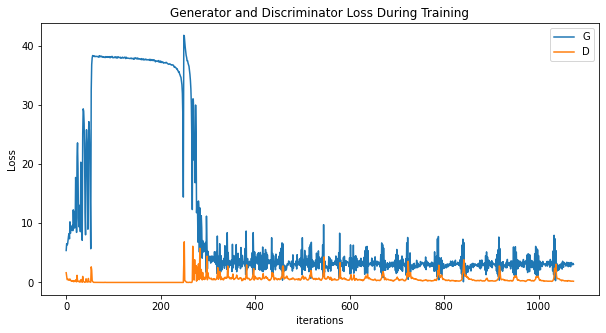

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Real Images vs Fake Images

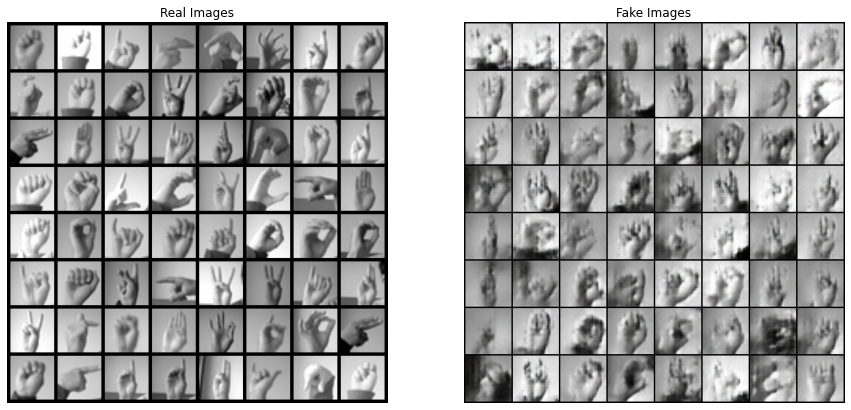

In [19]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()